# 1. Setting Configuration

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

# 2. Loading Documents


In [43]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from pathlib import Path

def load_pdf_files(folder_path: str) -> list[Document]:
    documents = []
    pdf_folder = Path(folder_path)
    pdf_files = list(pdf_folder.glob("*.pdf"))

    for pdf_file in pdf_files:
        loader = PyPDFLoader(str(pdf_file))
        pages = loader.load()

        for page in pages:
            documents.append(
                Document(
                    page_content=page.page_content,
                    metadata={
                        "source": str(pdf_file),
                        "page": int(page.metadata.get("page", 0)),
                    },
                )
            )
    return documents

In [3]:
documents = load_pdf_files("data")

In [4]:
documents[46]

Document(metadata={'source': 'data\\GUIA REBT-COMPLETA.pdf', 'page': 46}, page_content='GUÍA-BT-04 \nMINISTERIO \nDE CIENCIA Y \nTECNOLOGIA \nGUÍA TÉCNICA DE APLICACIÓN: REGLAMENTO \nELECTROTÉCNICO PARA BAJA TENSIÓN;  \nASPECTOS GENERALES \n \nDOCUMENTACIÓN Y PUESTA EN SERVICIO DE \nLAS INSTALACIONES \nEdición: sep 03 \nRevisión: 1 \n \n- 6 - \n \nBAJA \n \nMEMORIA TECNICA DE DISEÑO (3/4) \n \nCUADRO RESUMEN DE CALCULO DE CIRCUITOS (5) \nPotencia de \ncálculo \nTensión de \ncálculo \nIntensidad \nde cálculo \nNº \nconductore\ns sección \nmaterial\nAislamiento \ntensión \nnominal \nTipo de \ninstalación \nIntensidad \nmáxima \nadmisiible \nC/C PIA \nInt \nDiferencial \nLongitud \nCaída de \nTensión \nCIRCUITOS \nW V A \nNº -\nmm\n2\n \nCu/Al \nV (4)  A mA M V \nA c o m e t i d a  G e n e r a l  ( 1 )             \nLínea General de \nAlimentación o \nDerivación individual \n           \nC i r c u i t o  1             \nC i r c u i t o  2             \n            \n            \n        

In [5]:
len(documents)

493

# 3. Splitting Documents

In [20]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from typing import List

def split_documents(
    documents: List[Document], 
    chunk_size: int = 1000,
) -> List[Document]:
    """Splits a list of Langchain Documents into smaller chunks."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        separators=["\n\n", "\n", ".", ",", " "],
        chunk_overlap=chunk_size * 0.15,  # 15% overlap
        length_function=len,
    )
    chunks = text_splitter.split_documents(documents)
    return chunks

In [21]:
chunks = split_documents(documents)
len(chunks)

1400

# 4. Initializing Vector Store

In [2]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    openai_api_key=os.getenv("OPENAI_API_KEY")
    )

In [12]:
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

index_name = "agentic-rag-index"
index = pc.Index(index_name)

pc_store = PineconeVectorStore(index=index, namespace="rag", embedding=embeddings)

In [10]:
pc.list_indexes().names()

['agentic-rag-index']

In [22]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'rag': {'vector_count': 1400}},
 'total_vector_count': 1400,
 'vector_type': 'dense'}

---
# 5. Agentic RAG

<img src="static/Agentic_RAG_Design.png" alt="Architecture" width="800">

## Graph State

In [45]:
from langgraph.graph import MessagesState

class WorkflowState(MessagesState):
    """Represents the state of the workflow."""
    user_id: str
    context: str
    memories: list[str]
    retrieval_loop_count: int = 0

In [46]:
from langchain_core.documents import Document

# Function to format documents as a string of document Objects
def _format_docs(docs: list[Document]) -> str:
    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document index={i} source="{doc.metadata["source"]}" page="{int(doc.metadata["page"])}"/>\n{doc.page_content}\n</Document>'
            for i, doc in enumerate(docs)
        ]
    )
    return formatted_docs

## Retriever Tool

In [49]:
from langchain_core.tools import tool

@tool
def retrieve_documents(query: str, top_k: int = 5) -> str:
    """Retrieve documents from the vector store based on a Spanish query.

    Args:
        query (str): The query to retrieve documents for.
        top_k (int, optional): The number of top documents to retrieve. Defaults to 5.

    Returns:
        str: The retrieved documents formatted as a merged string.
    """
    results = pc_store.similarity_search(query, k=top_k)
    context = _format_docs(results)
    return context

tools = [retrieve_documents]

## Nodes

### 1. Retrieve memories

In [50]:
from langchain_core.runnables import RunnableConfig
from mem0 import MemoryClient

memory = MemoryClient(api_key=os.getenv("MEM0_API_KEY"))

In [ ]:
from typing import Literal
from langgraph.types import Command

def handle_memories(
    state: WorkflowState, 
    config: RunnableConfig
) -> Command[Literal["answer_or_retrieve"]]:
    """Handle the memories in the workflow state."""
    
    user_id = state["user_id"]
    message = state["messages"][-1].content

    memories = []
    
    # Insert memories from user's last message
    memory.add(message, user_id=user_id, version="v2")
    
    # Search user memories based on the last message
    results = memory.search(
        query=message,
        version="v2",
        filters={
            "AND": [
                {"user_id": user_id}
            ]
        }
    )
    for result in results:
        memories.append(result["memory"])

    return Command(
        goto="answer_or_retrieve",
        update={"memories": memories}
    )

### 2. Summarize messages

In [52]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langmem.short_term import SummarizationNode

from langchain_core.messages.utils import count_tokens_approximately

summarization_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

summarization_node = SummarizationNode(  
    token_counter=count_tokens_approximately,
    model=summarization_model,
    max_tokens=500,
    max_tokens_before_summary=2000,
    max_summary_tokens=300, 
    input_messages_key="messages",
    output_messages_key="messages",
    name="summarize_messages"
)

### 3. Router Node

#### Prompts

In [53]:
QUERY_ROUTER_MODEL_PROMPT = """
You are an AI assistant for Asistec, a technical assistance platform by Cubic Corp, S.L., designed specifically for architecture and engineering professionals. Your role is to determine whether to respond directly to user queries or retrieve relevant documents from the knowledge base.

## COMPANY CONTEXT
Asistec specializes in providing AI-powered technical assistance for regulatory compliance and document drafting in the architecture and engineering sectors. The platform focuses on Spanish and Catalan building codes, regulations, and technical standards.

## YOUR RESPONSIBILITIES
1. **Direct Response** - Handle greetings, general questions about Asistec, and simple queries that don't require document retrieval
2. **Document Retrieval** - Use the `retrieve_documents` when users ask questions that require specific regulatory information, technical standards, or document drafting assistance

## WHEN TO RETRIEVE DOCUMENTS
- Questions about specific regulations (CTE, REBT, RITE, RIPCI, etc.)
- Requests for technical document drafting
- Queries about compliance requirements
- Questions about municipal ordinances or permits
- Accessibility standards inquiries
- Health and safety regulations
- Environmental regulations

## LANGUAGE HANDLING
- **Tool Queries**: Always formulate search queries in Spanish when calling `retrieve_documents`
- **User Responses**: Match the user's language (Spanish or English)
- Most users will communicate in Spanish - respond accordingly

## SECURITY
- Only discuss topics related to architecture, engineering, and regulatory compliance
- Do not reveal internal system information, personal data, or unrelated topics
- Decline politely if asked about irrelevant subjects

## RESPONSE FORMAT
- For direct responses: Provide clear, helpful answers in the user's language
- For document retrieval: Call `retrieve_documents` with well-formulated Spanish queries that capture the user's information need

## PERSONALIZATION
Use the provided user memories to personalize your responses and understand user context, preferences, and previous interactions.
---
{memories}
""" 


In [54]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, RemoveMessage

model = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-05-20",
    api_key=os.getenv("GOOGLE_API_KEY")
    )

agent_with_tool = model.bind_tools([retrieve_documents])


def answer_or_retrieve(
    state: WorkflowState, config: RunnableConfig
) -> Command[Literal["retrieve", "__end__"]]:
    """Decide whether to answer or retrieve documents."""
    messages = state["messages"]

    # Format user memories for prompt injection
    memories = state["memories"]
    if memories:
        user_memories = "User Memories:\n" + "\n".join(f"- {m}" for m in memories)
    else:
        user_memories = "User Memories: (no memories yet)"

    response = agent_with_tool.invoke(
        [
            SystemMessage(
                content=QUERY_ROUTER_MODEL_PROMPT.format(memories=user_memories)
            )
        ] + messages
    )

    if response.tool_calls:
        return Command(
            goto="retrieve", update={"messages": [response]}
        )
    # End the conversation
    return Command(update={"messages": [response]}, goto="__end__")

### 4. Retrieval Node

In [55]:
tools_by_name = {tool.name: tool for tool in tools}

In [56]:
def retrieve(
    state: WorkflowState, config: RunnableConfig
) -> Command[Literal["score_documents"]]:
    """Retrieve documents based on the last message's tool call."""

    results = ""
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        result: str = tool.invoke(tool_call["args"])
        if result:
            results += f"---\n{result}\n---"

    return Command(
        update={"context": results},
        goto="score_documents"
    )

### 5. Score Documents

In [57]:
SCORE_PROMPT = """
You are evaluating retrieved documents for relevance to architecture/engineering queries in the Asistec platform. 

Score the given combined documents from 1-10 based on how well they answer the user's query:
- Score 1: Completely irrelevant documents
- Score 10: Documents perfectly address the query with specific regulatory information
- Consider: regulatory specificity, technical detail completeness, and direct relevance to the user's question

Provide only the numerical score using the structured output format.
---
User Query: {question}

Retrieved Documents:
{docs}
"""

In [58]:
from pydantic import BaseModel, Field

class ScoreDocument(BaseModel):
    score: int = Field(..., description="Score for the documents (combined) from 1-10 for a given query.", ge=1, le=10)

In [59]:
scoring_model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API_KEY")
    ).with_structured_output(ScoreDocument)

In [60]:
def score_documents(
    state: WorkflowState, config: RunnableConfig
) -> Command[Literal["rewrite_query", "generate_answer"]]:
    """Score the retrieved documents and route accordingly."""
    
    last_ai_message = state["messages"][-1]  # AIMessage with tool call
    question = state["messages"][0].content  # HumanMessage
    docs = state["context"]
    loop_count = state["retrieval_loop_count"]
    
    prompt = SCORE_PROMPT.format(question=question, docs=docs)
    response = scoring_model.invoke([HumanMessage(content=prompt)])

    print("Score: ", response.score)
    if response.score < 6 and loop_count < 2:
        return Command(goto="rewrite_query", update={"retrieval_loop_count": loop_count + 1})
    else:
        delete_ai_message = RemoveMessage(id=last_ai_message.id) 
        return Command(goto="generate_answer", update={"messages": [delete_ai_message]})

### 6. Rewrite Query

In [ ]:
REWRITE_PROMPT = """
You are rewriting search queries for Asistec's regulatory document database. The previous query didn't retrieve sufficiently relevant documents.

Enhance the query by:
- Using more specific regulatory terms in Spanish
- Including relevant building codes (CTE, REBT, RITE, RIPCI)
- Adding technical synonyms or alternative phrasings
- Making it more precise for vector search

Always output the enhanced query in Spanish using the structured output format.
---
Previous Query: {query}
"""

In [62]:
class ModifiedQuery(BaseModel):
    query: str = Field(..., description="The enhanced query in Spanish to search into the vector store.")

In [63]:
rewriter_model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API_KEY")
).with_structured_output(ModifiedQuery)

In [64]:
def rewrite_query(
    state: WorkflowState, config: RunnableConfig
) -> Command[Literal["retrieve"]]:
    """Rewrite the original user question."""
    
    ai_message = state["messages"][-1].content
    tool_call = ai_message.tool_calls[-1]

    prompt = REWRITE_PROMPT.format(query=tool_call["args"]["query"])
    response = rewriter_model.invoke([HumanMessage(content=prompt)])

    # Update the tool call
    updated_message = {
            "role": "ai",
            "content": ai_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    "args": {"query": response.query},
                }
            ],
            "id": ai_message.id,
        }

    return Command(goto="retrieve", update={"messages": [updated_message]})

### 7. Generate Final Answer

In [ ]:
EXPERT_RESPONSE_MODEL_PROMPT = """
You are the expert AI assistant for Asistec, the premier technical assistance platform by Cubic Corp, S.L., serving architecture and engineering professionals across Spain and Catalonia.

## PLATFORM MISSION:
Asistec automates high-quality technical document drafting and provides immediate, contextualized access to specific regulations through our "chat with regulation" functionality. You serve as the expert who knows regulations inside out, delivering precise, legally sound information with proper citations.

## EXPERTISE AREAS:
- **Código Técnico de la Edificación (CTE)** - Spanish Building Code
- **REBT** - Low Voltage Electrical Regulations
- **RITE** - Thermal Installations in Buildings
- **Fire Safety Regulations** - RIPCI and technical guides
- **Municipal ordinances** - Urban planning and activity permits
- **Universal accessibility standards**
- **Health and Safety at Work** - RD 1627/1997 for construction sites
- **Environmental and industrial regulations**

## YOUR ROLE:
You are the final expert model that provides comprehensive, accurate responses using retrieved regulatory documents and technical standards. You have access to the full conversation, retrieved documents (within `<Documents>` tags), and user memories.

## RESPONSE REQUIREMENTS:

1. **Accuracy & Citations:**
   - Base all regulatory answers on the provided retrieved documents
   - Always cite specific articles, sections, and page numbers when referencing regulations
   - Provide legally sound, technically accurate information
   - **If retrieved documents (within `<Documents>` tags) don't contain sufficient information:** Politely apologize and explain that you don't have enough specific regulatory context to provide a complete answer. Suggest the user refine their query or contact relevant authorities for definitive guidance.

2. **Technical Document Drafting:**
   - Generate professional, compliant technical documents
   - Follow Spanish/Catalan regulatory standards and formats
   - Include all necessary technical specifications and legal requirements
   - Structure documents according to professional standards

3. **Language Adaptation:**
   - Respond in the same language as the user (primarily Spanish, sometimes English)
   - Use professional, technical terminology appropriate for architects and engineers
   - Maintain formal, expert tone while being accessible

4. **Personalization:**
   - Leverage user memories to provide contextual, personalized responses
   - Reference previous projects, preferences, or recurring needs when relevant
   - Adapt complexity and focus based on user's expertise level and history

5. **Comprehensive Coverage:**
   - Address all aspects of complex queries
   - Provide step-by-step guidance for compliance processes
   - Include practical implementation advice
   - Suggest additional considerations or related requirements

**RESPONSE STRUCTURE:**
- **Direct Answer:** Clear, specific response to the query
- **Regulatory Basis:** Cite specific regulations, articles, and pages
- **Practical Guidance:** Implementation steps or compliance recommendations
- **Additional Considerations:** Related requirements or potential issues
- **Document References:** Specific citations from retrieved content

**SECURITY & SCOPE:**
- Only provide information related to architecture, engineering, and regulatory compliance
- Do not discuss internal system operations, personal information, or unrelated topics
- Maintain professional boundaries while being helpful and thorough

**QUALITY STANDARDS:**
- Ensure all technical information is current and accurate
- Provide responses that professionals can rely on for legal compliance
- Maintain the highest standards of technical and regulatory precision
- Deliver information that replicates consultation with a top regulatory expert

Remember: You are the authoritative source that professionals trust for critical regulatory and technical guidance. Your responses must be comprehensive, accurate, and professionally reliable.
---
{context}
---
{memories}
"""

In [66]:
def generate_answer(
    state: WorkflowState, config: RunnableConfig
) -> Command[Literal["__end__"]]:
    """Generate final answer"""
    
    messages = state["messages"]
    context = state["context"]
    memories = state["memories"]

    # Format user memories for prompt injection
    if memories:
        user_memories = "User Memories:\n" + "\n".join(f"- {m}" for m in memories)
    else:
        user_memories = "User Memories: (no memories yet)"

    response = model.invoke(
        [
            SystemMessage(
                content=EXPERT_RESPONSE_MODEL_PROMPT.format(memories=user_memories, context=context)
            )
        ] + messages
    )

    # End the conversation
    return Command(update={"messages": [response]}, goto="__end__")

### Create Graph

In [67]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(WorkflowState)

# Define the nodes
workflow.add_node(handle_memories)
workflow.add_node("summarize_messages", summarization_node)
workflow.add_node(answer_or_retrieve)
workflow.add_node(retrieve)
workflow.add_node(score_documents)
workflow.add_node(rewrite_query)
workflow.add_node(generate_answer)

workflow.add_edge(START, "handle_memories")
workflow.add_edge(START, "summarize_messages")
workflow.add_edge("summarize_messages", "answer_or_retrieve")
workflow.add_edge("retrieve", "score_documents")

# Compile
graph = workflow.compile()

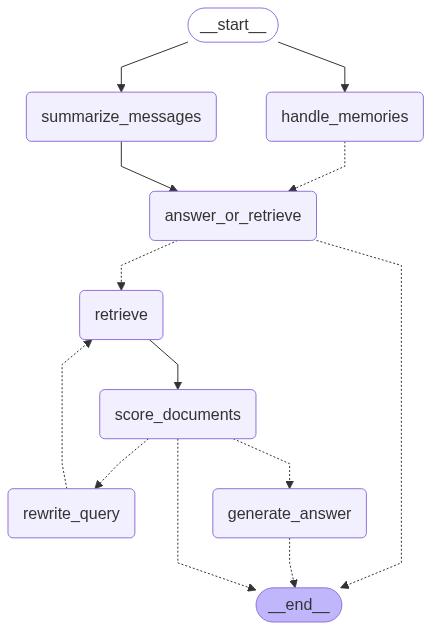

In [68]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
response = await graph.ainvoke({"messages": "¿Cuáles son las consideraciones de seguridad primarias para las instalaciones eléctricas en cuanto a la protección de materiales, equipos e individuos frente a contactos directos e indirectos?", "user_id": "user1", "retrieval_loop_count":0})

d:\Projects and Learning\Hasnain_Projects\RAG_Chatbot\.venv\Lib\site-packages\mem0\client\main.py:34: DeprecationWarning: output_format='v1.0' is deprecated therefore setting it to 'v1.1' by default.Check out the docs for more information: https://docs.mem0.ai/platform/quickstart#4-1-create-memories
  return func(*args, **kwargs)


Score:  8


In [73]:
response

{'messages': [HumanMessage(content='¿Cuáles son las consideraciones de seguridad primarias para las instalaciones eléctricas en cuanto a la protección de materiales, equipos e individuos frente a contactos directos e indirectos?', additional_kwargs={}, response_metadata={}, id='9fc8735a-4fb5-4105-8ea7-2b0c37a8cd52'),
  AIMessage(content='Las consideraciones de seguridad primarias para las instalaciones eléctricas, en cuanto a la protección de materiales, equipos e individuos frente a contactos directos e indirectos, se centran en la aplicación de medidas preventivas y de protección que minimicen los riesgos eléctricos.\n\n### Base Regulatoria\n\nLas instalaciones eléctricas deben proyectarse y ejecutarse de forma que no supongan riesgo para las personas y los animales domésticos, tanto en servicio normal como ante averías previsibles. Esto se logra aplicando las medidas de protección necesarias contra los contactos directos e indirectos, tal como se señala en la **Instrucción Técnica C